In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6

In [2]:
dataset=pd.read_excel(r"C:\Users\Ramana Reddy (Rakhi)\OneDrive\Desktop\crypto project\litecoin.xlsx")
dataset

,ticker,date,open,high,low,close
0,LTC,2017-01-01,4.3200,4.5000,4.2600,4.4200
1,LTC,2017-01-02,4.4200,4.6900,4.3700,4.5400
2,LTC,2017-01-03,4.5400,4.6300,4.4200,4.5100
3,LTC,2017-01-04,4.5100,4.7300,4.3600,4.4200
4,LTC,2017-01-05,4.4200,4.6300,3.9500,4.1600
...,...,...,...,...,...,...
2731,LTC,2024-06-26,71.4164,71.9255,70.3789,71.1616
2732,LTC,2024-06-27,71.1659,73.0154,70.4710,72.9122
2733,LTC,2024-06-28,72.9122,74.6588,72.4539,73.0244
2734,LTC,2024-06-29,73.0244,76.7071,72.6787,75.5014


In [3]:
dataset['date']=pd.to_datetime(dataset['date'],infer_datetime_format=True)
indexedDataset= dataset.set_index(['date'])

In [4]:
indexedDataset=indexedDataset.drop(columns=['ticker','high','low','open'])
indexedDataset=indexedDataset.resample('M').mean()
indexedDataset.head()

,close
date,
2017-01-31,3.968710
2017-02-28,3.839643
2017-03-31,4.260323
2017-04-30,11.772333
2017-05-31,26.048387


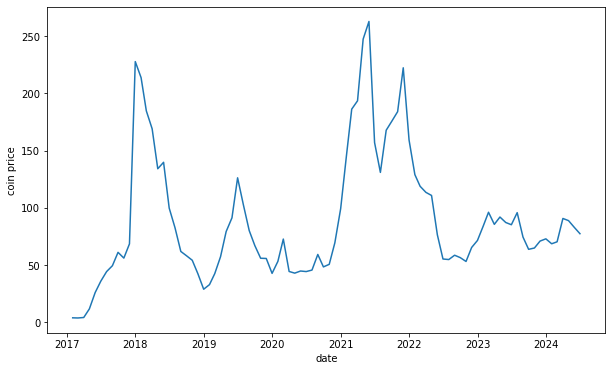

In [5]:
plt.xlabel('date')
plt.ylabel('coin price')
plt.plot(indexedDataset)

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #determing rolling statistics
    moving_avg=timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(moving_avg,color='red',label='rolling mean' )
    std=plt.plot(moving_std,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.show(block=False)
    #perform Dickey fuller test;
    print("results of Dickey-fuller test:")
    dftest=adfuller(timeseries['close'],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','lags used','number of Observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]=value
    print(dfoutput)

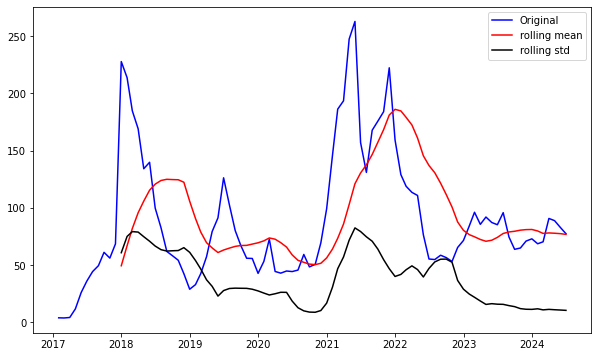

results of Dickey-fuller test:
Test statistic                 -3.149638
p-value                         0.023091
lags used                       1.000000
number of Observations used    88.000000
Critical value (1%)            -3.506944
Critical value (5%)            -2.894990
Critical value (10%)           -2.584615
dtype: float64


In [7]:
test_stationarity(indexedDataset)

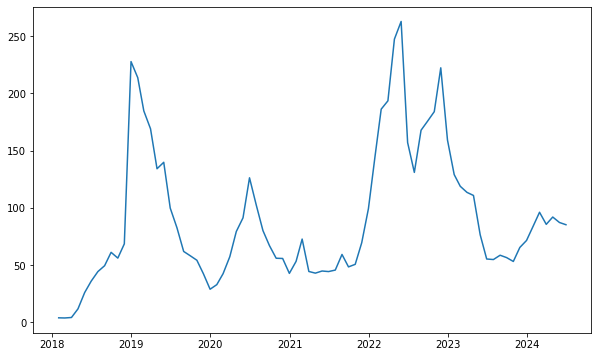

In [8]:
#estimating trend
indexedDataset_shift=indexedDataset.shift(12).dropna()
plt.plot(indexedDataset_shift)

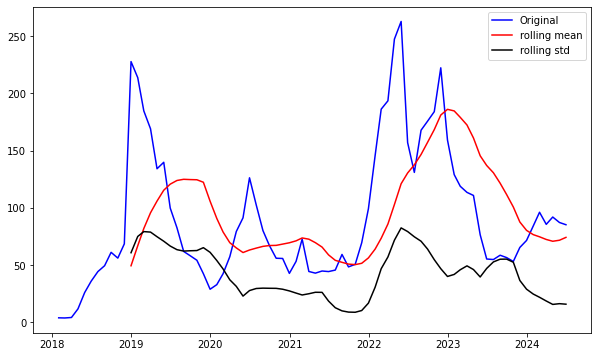

results of Dickey-fuller test:
Test statistic                 -2.936312
p-value                         0.041285
lags used                       1.000000
number of Observations used    76.000000
Critical value (1%)            -3.519481
Critical value (5%)            -2.900395
Critical value (10%)           -2.587498
dtype: float64


In [9]:
test_stationarity(indexedDataset_shift)

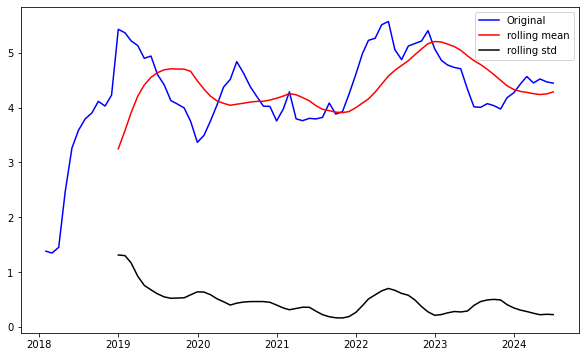

results of Dickey-fuller test:
Test statistic                 -4.462001
p-value                         0.000230
lags used                       1.000000
number of Observations used    76.000000
Critical value (1%)            -3.519481
Critical value (5%)            -2.900395
Critical value (10%)           -2.587498
dtype: float64


In [10]:
indexedDataset_logscale=np.log(indexedDataset_shift)
test_stationarity(indexedDataset_logscale)

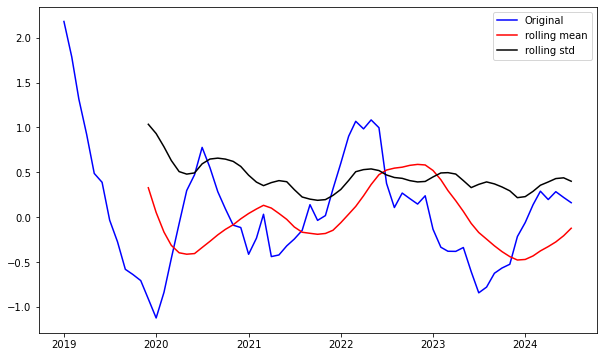

results of Dickey-fuller test:
Test statistic                 -3.775464
p-value                         0.003169
lags used                       3.000000
number of Observations used    63.000000
Critical value (1%)            -3.538695
Critical value (5%)            -2.908645
Critical value (10%)           -2.591897
dtype: float64


In [11]:
moving_avg=indexedDataset_logscale.rolling(window=12).mean()
datasetlogscale_moving_avg=indexedDataset_logscale-moving_avg
datasetlogscale_moving_avg.head(12)
#remove nan values
datasetlogscale_moving_avg.dropna(inplace=True)
test_stationarity(datasetlogscale_moving_avg)

# Seasonal Decompose

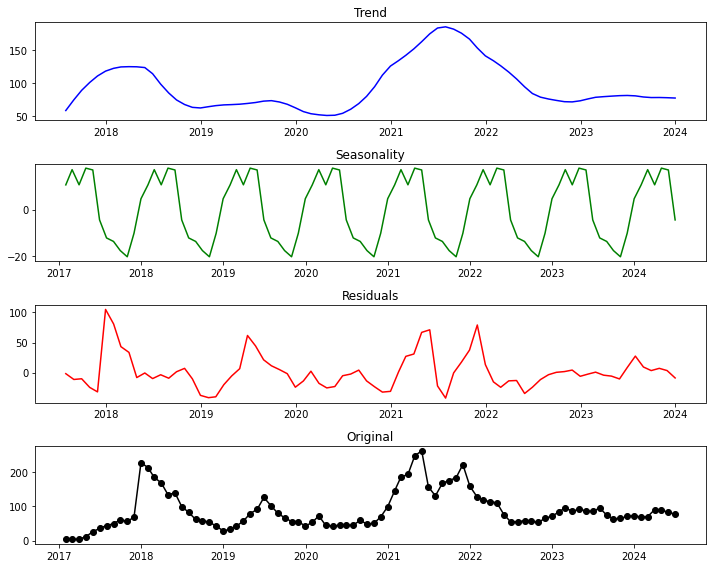

In [12]:
decomposition = seasonal_decompose(indexedDataset, model='additive')
plt.figure(figsize=(10,8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals')

plt.subplot(4, 1, 4)
plt.plot(indexedDataset.index,indexedDataset.values, marker='o', linestyle='-', label='Original', color='black')
plt.title('Original')

plt.tight_layout()
plt.show()

# AUTO CORRELATION AND PARTIAL AUTOCORRELATION graphs

C:\Users\Ramana Reddy (Rakhi)\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


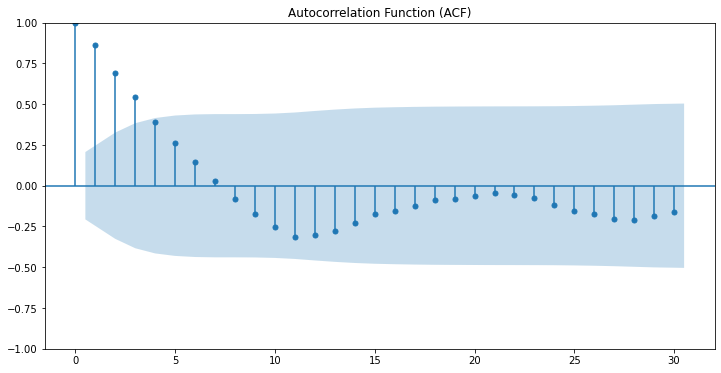

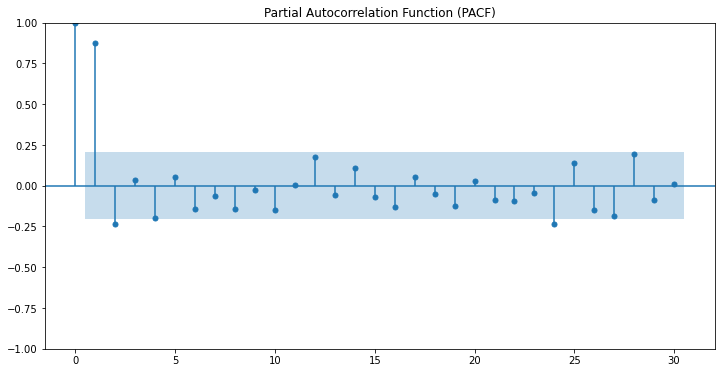

In [13]:
import statsmodels.api as sm

# Plot ACF
fig, ax1 = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(indexedDataset['close'], lags=30, ax=ax1)
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
fig, ax2 = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(indexedDataset['close'], lags=30, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

In [14]:
# Split data into train and test sets
X = np.arange(len(indexedDataset)).reshape(-1, 1)
y = indexedDataset.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(72, 1)
(72, 1)
(18, 1)
(18, 1)


C:\Users\Ramana Reddy (Rakhi)\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -341.629
Date:                Fri, 23 Aug 2024   AIC                            699.257
Time:                        22:04:45   BIC                            717.471
Sample:                             0   HQIC                           706.508
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.2520     18.831      4.793      0.000      53.345     127.159
ar.L1          1.1742      0.380      3.089      0.002       0.429       1.919
ar.L2          0.3621      0.691      0.524      0.600      -0.993       1.717
ar.L3         -0.5766      0.335     -1.722      0.085      -1.233       0.080
ma.L1         -0.1116      2.089     -0.053      0.957      -4.205       3.982
ma.L2         -0.8802      1.986     -0.443      0.658      -4.773       3.013
ma.L3         -0.0042      0.283     -0.015      0.988      -0.559       0.551
sigma2       734.6348   1479.077      0.497      0.619   -2164.304    3633.573
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               303.38
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.88
Prob(H) (two-sided):                  0.55   Kurtosis:                        12.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

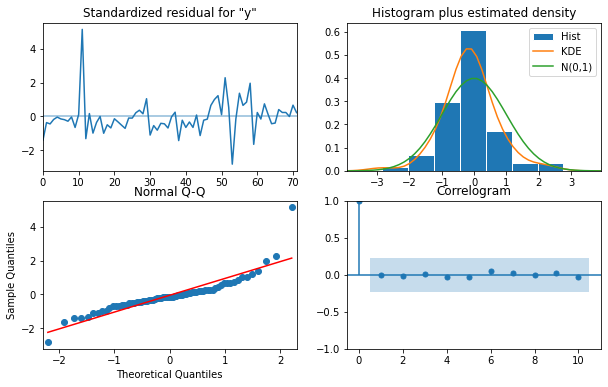

In [16]:
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMA model
arima_model = ARIMA(y_train,order=(3,0,3))
pred_arima = arima_model.fit()
predicion=pred_arima.plot_diagnostics()
pred_arima.summary()

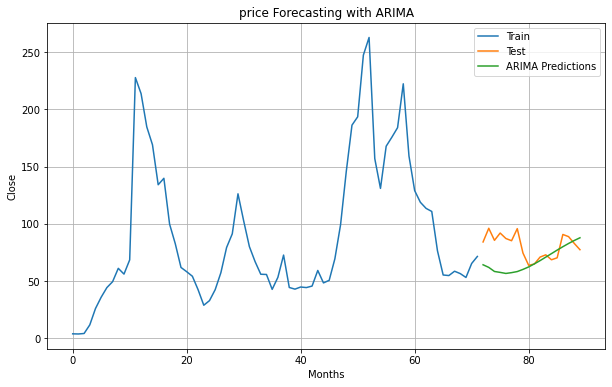

In [17]:
arima_predictions =pred_arima.forecast(steps=len(X_test))
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, label='Train')
plt.plot(X_test, y_test, label='Test')
plt.plot(X_test, arima_predictions, label='ARIMA Predictions')
plt.title('price Forecasting with ARIMA')
plt.xlabel('Months')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
index_future_date=pd.date_range(start='2024-06-30',end='2024-09-25')
print(index_future_date)
pred=pred_arima.predict(start=len(indexedDataset),end=len(indexedDataset)+50,typ='levels')
#print(comp_pred)
predindex=index_future_date
dataframe=pd.DataFrame(pred)
dataframe.head(10)

DatetimeIndex(['2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
               '2024-07-28', '2024-07-29', '2024-07-30', '2024-07-31',
               '2024-08-01', '2024-08-02', '2024-08-03', '2024-08-04',
               '2024-08-05', '2024-08-06', '2024-08-07', '2024-08-08',
               '2024-08-09', '2024-08-10', '2024-08-11', '2024-08-12',
               '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',
               '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-20',
               '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-24',
      

,0
0,89.921894
1,91.758426
2,93.309042
3,94.577457
4,95.569467
5,96.299577
6,96.784778
7,97.046932
8,97.109498
9,96.998143


<AxesSubplot:>

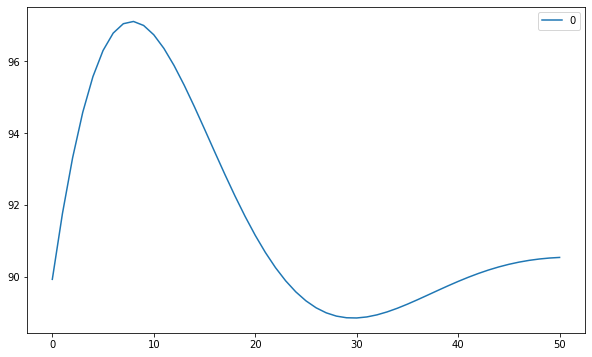

In [19]:
dataframe.plot()

In [20]:
print(mean_absolute_error(y_test,arima_predictions))
print(mean_squared_error(y_test,arima_predictions))
print(r2_score(y_test,arima_predictions))

15.223351018599338
397.1835187581687
-2.8541858932590163
